# Python

***
###  

In [1]:
# Python import 
import os
import copy
import collections
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import statsmodels.stats.multitest as multi
from scipy.stats import pearsonr
from sklearn.externals import joblib
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

##  1. Load files (Feature Matrix,Label,and RNA-Light)  

In [2]:
input_path = "../03_Model_Construction/01_Machine_Learning_Model/01_ML_Model_Output"
RNA_Light_path = os.path.join(input_path,"LightGBM")
output_path = "./01_SHAP_kmer_Output"
if not (os.path.exists(output_path)):
    os.mkdir(output_path)

# load kmer file
df_kmer_345 = pd.read_csv(os.path.join(input_path,"df_kmer345_freq.tsv"),sep='\t',index_col= 0)
transcript_id = df_kmer_345['ensembl_transcript_id']
# convert to x:kmer-freq , y:label
del df_kmer_345['ensembl_transcript_id']
x_kmer = df_kmer_345.values
y_kmer = np.array(df_kmer_345.index)

# load model
RNA_Light = joblib.load(os.path.join(RNA_Light_path,"best_LightGBM_model.pkl"))

In [3]:
df_kmer_345.head()

,AAA,AAAA,AAAAA,AAAAC,AAAAG,AAAAT,AAAC,AAACA,AAACC,AAACG,...,TTTG,TTTGA,TTTGC,TTTGG,TTTGT,TTTT,TTTTA,TTTTC,TTTTG,TTTTT
tag,,,,,,,,,,,,,,,,,,,,,
1,0.007616,0.001792,0.000538,0.000538,0.000627,0.000627,0.001523,0.000448,0.000538,0.000090,...,0.002688,0.000627,0.000627,0.000448,0.000986,0.002778,0.000806,0.000806,0.000986,0.000806
1,0.005559,0.001255,0.000448,0.000269,0.000448,0.000448,0.001704,0.000717,0.000448,0.000000,...,0.002780,0.000628,0.000359,0.000807,0.000986,0.002421,0.000717,0.001076,0.000448,0.001076
1,0.004292,0.001262,0.000252,0.000126,0.000757,0.000379,0.001262,0.000252,0.000252,0.000126,...,0.002651,0.000505,0.000505,0.000757,0.000884,0.003156,0.000126,0.000884,0.001515,0.001389
1,0.007358,0.002835,0.001195,0.000703,0.000820,0.001172,0.001945,0.000680,0.000609,0.000070,...,0.002132,0.000633,0.000398,0.000492,0.000609,0.002859,0.001242,0.000539,0.000961,0.001101
1,0.008287,0.003030,0.001158,0.000535,0.000980,0.001515,0.001693,0.000980,0.000446,0.000089,...,0.003208,0.001069,0.000267,0.000713,0.001158,0.005168,0.001069,0.001871,0.001693,0.002406


***
###  

## 2. Interpret model by shapely value

In [4]:
shap.initjs() 
# Interpret the model's predictions on the entire dataset for nuclear/cytosol localization 
RNA_Light_explainer = shap.TreeExplainer(RNA_Light)
shap_values_RNA_Light = RNA_Light_explainer.shap_values(df_kmer_345)[1]

# Convert np.array to dataframe with column names
shap_df = pd.DataFrame(shap_values_RNA_Light,columns = df_kmer_345.columns)
shap_df.index = transcript_id 
shap_df.to_csv(os.path.join(output_path,"RNA-Light_mRNA_shap_df.txt"),sep='\t')

# Mean(abs(shap_value))
mean_abs_shap_val = shap_df.apply(lambda x:abs(x).mean(),axis=0)

# Calculate pearson correlation
mRNA_num = shap_df.shape[0]
total_df = pd.concat([df_kmer_345,shap_df])
# Pearson correlation coefficient (r and p_value)
pearsonr_r = total_df.apply(lambda x:pearsonr(x[:mRNA_num],x[mRNA_num:2*mRNA_num])[0],axis=0)
pearsonr_p = total_df.apply(lambda x:pearsonr(x[:mRNA_num],x[mRNA_num:2*mRNA_num])[1],axis=0)
fdr =pd.Series(multi.multipletests(pearsonr_p)[1],index = pearsonr_p.index)

# Merge to kmer_info ["mean_abs_shap","pearsonr_r","pearsonr_p","fdr"]
kmer_info_df = pd.concat([mean_abs_shap_val,pearsonr_r,pearsonr_p,fdr],axis=1) 
kmer_info_df.columns = ["mean_abs_shap","pearsonr_r","pearsonr_p","fdr"]

kmer_info_df.to_csv(os.path.join(output_path,"kmer_importance_quantification_info.txt"),sep='\t')

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


<Figure size 432x288 with 0 Axes>

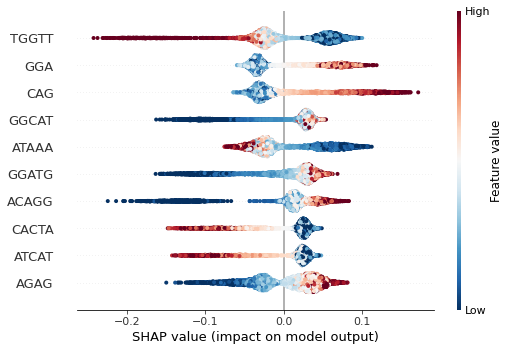

In [5]:
# Define colormap
my_colormap= plt.get_cmap("RdBu_r")

# Plot the summary without showing it
plt.figure()
shap.summary_plot(shap_values_RNA_Light,features =df_kmer_345,max_display = 10,show=False)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_colormap)
plt.savefig(os.path.join(output_path,"SHAP_total_top10_kmer.pdf"), format='pdf', dpi=1200)

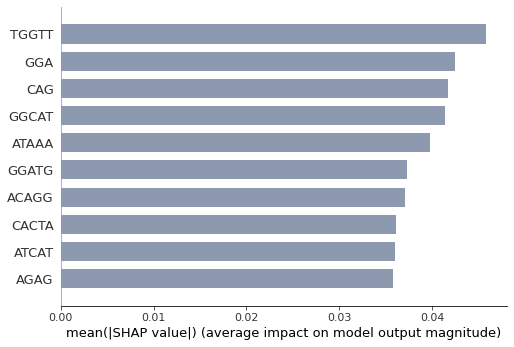

In [6]:
shap.summary_plot(shap_values_RNA_Light,df_kmer_345,plot_type = "bar",max_display = 10,color = "#8d99ae",show = False)
plt.savefig(os.path.join(output_path,"SHAP_total_top10_kmer_bar.pdf"), format='pdf', dpi=1200)